In [1]:
import numpy as np
import numpy.random as nrd
import matplotlib.pyplot as plt

from scipy.stats import chi2
from sklearn.tree import DecisionTreeClassifier

# Exercise 10.4

(a) Write a program implementing AdaBoost with trees.

(b) Redo the computations for the example of Figure 10.2. Plot the training error as well as test error, and discuss its behavior.

(c) Investigate the number of iterations needed to make the test error finally start to rise.

(d) Change the setup of this example as follows: define two classes, with the features in Class 1 being X1,X2, . . . ,X10, standard independent Gaussian variates. In Class 2, the features X1,X2, . . . ,X10 are also standard independent Gaussian, P but conditioned on the event $\sum_j X^2_j > 12$. Now the classes have significant overlap in feature space. Repeat the AdaBoost experiments as in Figure 10.2 and discuss the results.

# Solution

The AdaBoost algorithm using a stump (tree with 2 leafs), as descrobed in Chp 10,

In [2]:
class AdaBoostTree:
    
    def __init__(self,*args,**kwargs):
        
        self.args = args
        self.kwargs = kwargs
        
        self.summary = {}
        
    def run(self,X,y,max_iter):
        
        N,p = X.shape
        
        self.summary['alpha'] = []
        self.summary['model'] = []
        self.summary['max_iteration'] = max_iter
        
        # Initialize weights
        w = np.full(N,1/N)
        
        for i in range(max_iter):
            
            # fit model to data with wights
            model = DecisionTreeClassifier(*self.args,**self.kwargs)
            model.fit(X,y,sample_weight=w)
            
            # compute the error
            error = 1 - model.score(X,y,sample_weight=w)
            alpha = np.log((1-error)/error)
            
            # update weights
            y_predicted = model.predict(X)
            indicator_function = y_predicted != y
            w = w*np.exp(alpha * indicator_function)
            
            self.summary['alpha'].append(alpha)
            self.summary['model'].append(model)
            
    def predict(self,X,iteration=-1):
        
        end = iteration % self.summary['max_iteration']
        
        alphas = self.summary['alpha'][:end+1]
        Gs = self.summary['model'][:end+1]
        
        outcome = []
        
        for alpha,G in zip(alphas,Gs):
            outcome.append(alpha*G.predict(X))
            
        votes = np.sum(outcome,axis=0)
        
        return np.sign(votes)
    
    def error_curve(self,X,y):
        
        error_list = []
        
        for iteration in range(self.summary['max_iteration']):
            y_predicted = self.predict(X,iteration)
            error = np.mean(y_predicted != y)
            error_list.append(error)
            
        return error_list

### Data with no overlap (it is possible to distinguish between the two classes)

In [3]:
# N data points, generated by sampling p independent Gaussian distributions
N_train = 2000
N_test = 10000
p = 10

X_train = nrd.normal(size=(N_train,p))
X_test = nrd.normal(size=(N_test,p))

# Set the value of y
treshold = chi2.median(p)
classify = lambda v : (-1)**(v @ v <= treshold)
y_train = np.apply_along_axis(classify,1,X_train)
y_test = np.apply_along_axis(classify,1,X_test)

Applying algorithm to data,

In [4]:
# Number of iterations
M = 1500

# Fit the model
example1 = AdaBoostTree(max_leaf_nodes=2)
example1.run(X_train,y_train,max_iter=M)

# Learning curves
train_error = example1.error_curve(X_train,y_train)
test_error = example1.error_curve(X_test,y_test)

And a single, optimal tree,

In [5]:
optimal_tree = DecisionTreeClassifier()
optimal_tree.fit(X_train,y_train)

# Get leafs and classification error
opt_leafs = optimal_tree.get_n_leaves()
opt_error = 1-optimal_tree.score(X_test,y_test)

Let us plot the learning curves,

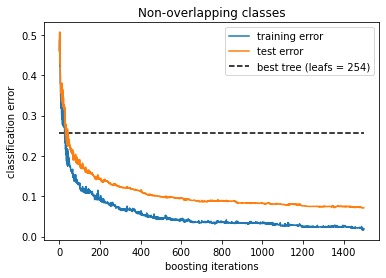

In [6]:
iterations_list = np.arange(M,dtype=int)
plt.plot(iterations_list,train_error,label='training error')
plt.plot(iterations_list,test_error,label='test error')
plt.hlines(opt_error, 0, M-1, colors='k', linestyles='--',label='best tree (leafs = {})'.format(opt_leafs))
plt.title('Non-overlapping classes')
plt.xlabel('boosting iterations')
plt.ylabel('classification error')
plt.legend()
plt.show()

I tryied to check when the procedure overfits, so that test error increases. I stopped here since it took to long.

### Data with overlap

In [7]:
def data_generation_two_classes(N,p,treshold):
    
    # Class 1 : sampled from p independent Gaussian distributions
    class1 = nrd.normal(size=(N//2,p))
    class1 = np.hstack((class1,np.full((N//2,1),1)))

    # Class 2 : sampled from p independent Gaussian distributions but conditioned on inner product

    # To approximately get a balance number of observations in class 2, we first generate
    N_class2 = int(N/(2*(1-chi2.cdf(treshold,p))))

    class2 = nrd.normal(size=(N_class2,p))
    keep = lambda v : v @ v > treshold
    keep_bool = np.apply_along_axis(keep,1,class2)
    class2 = class2[keep_bool]

    n,_ = class2.shape
    class2 = np.hstack((class2,np.full((n,1),-1)))
    
    data = np.concatenate((class1,class2))
    
    # Shuffle the data
    rng = nrd.default_rng()
    rng.shuffle(data)
    
    X = data[:,:-1]
    y = data[:,-1]
    
    return X,y

Let's generate the data with overlap,

In [8]:
N_train = 2000
N_test = 10000
p = 10
treshold = 12

X_train,y_train = data_generation_two_classes(N_train,p,treshold)
X_test,y_test = data_generation_two_classes(N_test,p,treshold)

And apply our algorithm,

In [9]:
# Number of iterations
M = 1000

# Fit the model
example2 = AdaBoostTree(max_leaf_nodes=2)
example2.run(X_train,y_train,max_iter=M)

# Learning curves
train_error = example2.error_curve(X_train,y_train)
test_error = example2.error_curve(X_test,y_test)

And again, a single optimal tree,

In [10]:
optimal_tree = DecisionTreeClassifier()
optimal_tree.fit(X_train,y_train)

# Get leafs and classification error
opt_leafs = optimal_tree.get_n_leaves()
opt_error = 1-optimal_tree.score(X_test,y_test)

The learning curves are,

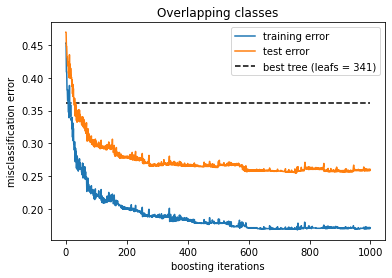

In [11]:
iterations_list = np.arange(M,dtype=int)
plt.plot(iterations_list,train_error,label='training error')
plt.plot(iterations_list,test_error,label='test error')
plt.hlines(opt_error, 0, M-1, colors='k', linestyles='--',label='best tree (leafs = {})'.format(opt_leafs))
plt.title('Overlapping classes')
plt.xlabel('boosting iterations')
plt.ylabel('misclassification error')
plt.legend()
plt.show()

As noted in the main text, we see how AdaBoost sacrifices the robustnes of trees to overlapping classes. Still, AdaBoost outperforms the best single tree.